In [1]:
!pip install open_clip_torch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 19.4 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.0/43.0 kB 2.4 MB/s eta 0:00:00


In [2]:
import os
import re
import json
import math
import time
import numpy as np
import scipy
import scipy.linalg
import random
import gc
import PIL
from PIL import Image, ImageDraw, ImageFont
from IPython.display import clear_output

import pickle
from torch.utils import data

import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg', 'pdf') # For export
from matplotlib.colors import to_rgb
import matplotlib
# matplotlib.rcParams['lines.linewidth'] = 2.0
# import seaborn as sns
# sns.set()

# from tqdm.notebook import tqdm
from tqdm import tqdm


from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
from torch.utils.data import Subset, DataLoader
import torch.optim as optim

import torchvision
from torchvision import transforms

from functools import lru_cache

# ignore warnings
import warnings
warnings.filterwarnings("ignore")

import random
from collections import Counter


/tmp/ipykernel_34/2369787748.py:21: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('svg', 'pdf') # For export


In [3]:
def seed_everything(SEED=42):
    random.seed(SEED)
    np.random.seed(SEED)
    torch.manual_seed(SEED)
    
    torch.cuda.manual_seed(SEED)
    torch.cuda.manual_seed_all(SEED)
    
    torch.backends.cudnn.benchmark = True # as we will resize the images
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.enabled = True


SEED=42
seed_everything(SEED=SEED)

# Fetching the device that will be used throughout this notebook
device = torch.device("cpu") if not torch.cuda.is_available() else torch.device("cuda:0")
print("Using device", device)

Using device cuda:0


In [4]:
import open_clip

# model, _, preprocess = open_clip.create_model_and_transforms('ViT-B-16', pretrained='openai')
# model, _, preprocess = open_clip.create_model_and_transforms('ViT-L-14-336', pretrained='openai')

model, _, preprocess = open_clip.create_model_and_transforms('ViT-L-14', pretrained='openai')
# model, _, preprocess = open_clip.create_model_and_transforms('ViT-B-16-SigLIP', pretrained='webli')


# model, _, preprocess = open_clip.create_model_and_transforms('ViT-H-14', pretrained='laion2b_s32b_b79k')

# model = nn.DataParallel(model, device_ids=[0, 1])

model.eval()  # model in train mode by default, impacts some models with BatchNorm or stochastic depth active

# already have tokenized embeddings, just load them
# tokenizer = open_clip.get_tokenizer('ViT-B-16')
# tokenizer = open_clip.get_tokenizer('ViT-L-14-336')

# tokenizer = open_clip.get_tokenizer('ViT-L-14')
# tokenizer = open_clip.get_tokenizer('ViT-H-14')

100%|████████████████████████████████████████| 933M/933M [00:07<00:00, 126MiB/s]


CLIP(
  (visual): VisionTransformer(
    (conv1): Conv2d(3, 1024, kernel_size=(14, 14), stride=(14, 14), bias=False)
    (patch_dropout): Identity()
    (ln_pre): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
    (transformer): Transformer(
      (resblocks): ModuleList(
        (0-23): 24 x ResidualAttentionBlock(
          (ln_1): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
          (attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=1024, out_features=1024, bias=True)
          )
          (ls_1): Identity()
          (ln_2): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
          (mlp): Sequential(
            (c_fc): Linear(in_features=1024, out_features=4096, bias=True)
            (gelu): QuickGELU()
            (c_proj): Linear(in_features=4096, out_features=1024, bias=True)
          )
          (ls_2): Identity()
        )
      )
    )
    (ln_post): LayerNorm((1024,), eps=1e-05, elementwise_affine=Tru

In [5]:
!kaggle datasets download -d jessicali9530/caltech256
!unzip -q caltech256.zip -d caltech256

Dataset URL: https://www.kaggle.com/datasets/jessicali9530/caltech256
License(s): other
 99%|██████████████████████████████████████▊| 2.11G/2.12G [00:15<00:00, 198MB/s]
100%|███████████████████████████████████████| 2.12G/2.12G [00:15<00:00, 151MB/s]


In [6]:
my_preprocess = transforms.Compose([
#     transforms.ToTensor(),
#     transforms.PILToTensor(),  # [0, 255] range, uint8
    
    preprocess.transforms[0],
#     transforms.Resize(224, interpolation=transforms.InterpolationMode.BICUBIC),
    
    preprocess.transforms[1], # can cut some part of the patch (omit for SigLIP)
#     transforms.CenterCrop((224, 224)),  
    
#     transforms.ToTensor(),
#     transforms.Lambda(lambda x: x / 255),  # from [0, 255] to [0, 1] range
    
#     transforms.Normalize(mean=(0.48145466, 0.4578275, 0.40821073), std=(0.26862954, 0.26130258, 0.27577711)),
    preprocess.transforms[-1],
])


my_preprocess_frame = transforms.Compose([
    transforms.Resize((224, 224), interpolation=transforms.InterpolationMode.BICUBIC),
    preprocess.transforms[-1],
])

In [7]:
# text_features = torch.load('/kaggle/input/text-f-data/text_features_ViT-B-16.pt').detach()
text_features = torch.load('/kaggle/input/text-f-data/text_features_ViT-L-14.pt').detach()
# text_features = torch.load('/kaggle/input/text-f-data-all/text_features_ViT-L-14-336.pt').detach()

# tokenizer = open_clip.get_tokenizer('ViT-L-14-336')
# tokenizer = open_clip.get_tokenizer('ViT-B-16')

# text_features = torch.cat((text_features, mean_emb), 0)

model = model.to(device)
text_features = text_features.to(device)


def my_collate(batch):
    data, target = [], []
    for (data_item, target_item) in batch:
        data.append(data_item)
        target.append(target_item)

    target = torch.LongTensor(target)
    return [data, target]


def get_data(bs, seed=SEED):
    data_transforms = torchvision.transforms.Compose([
        transforms.ToTensor()  # from [0, 255] PIL-range to [0, 1] torch-range
    ])
    dataset = torchvision.datasets.ImageFolder('/kaggle/working/caltech256/256_ObjectCategories', transform=data_transforms)
    label_names = [re.sub(r"^\d+\.\s*", "", item) for item in dataset.classes]

    ind = list(range(0, len(dataset), 3)) # were 20 (86), 3
    subset = torch.utils.data.Subset(dataset, ind)
    
    s = [dataset.targets[i] for i in ind]
    assert len(Counter(s).keys()) == len(label_names), "Not all labels are in the subset"
    
    del dataset
    torch.cuda.empty_cache()
    gc.collect()
    
    # Leave a small set of images out to check generalization
    batch_size = bs  # 82 for ViT-B-16; 64 with additional loss; 16 for ViT-L-14; 10 for ViT-L-336

    train_size = round(0.7 * len(subset))
    generator1 = torch.Generator().manual_seed(seed)
    train_set, test_set = torch.utils.data.random_split(subset, [train_size, len(subset) - train_size], generator=generator1)
    
    train_loader = data.DataLoader(train_set, batch_size=batch_size, shuffle=True, drop_last=True, num_workers=4, collate_fn=my_collate)
    test_loader = data.DataLoader(test_set, batch_size=batch_size, shuffle=False, drop_last=False, num_workers=4, collate_fn=my_collate)
    
    return train_loader, test_loader, label_names
    

In [8]:
def SingleAnchorDPR(r, patch_shape, num_regions=6, device='cpu', cc=-100):
    '''
    Code borrowed and optimized from here: https://www.ecva.net/papers/eccv_2022/papers_ECCV/papers/136640522.pdf
    
    :param r: [bs, num_regions], require_grad=True
    :param num_regions: int > 3
    :param (h, w): (int, int)
    :return: act, [bs, h, w]
    '''
    
    _, h, w = patch_shape
    assert h == w, 'The h and w should be equal!'
    bs = r.shape[0]
    assert r.shape[1] == num_regions, 'The length of r should be equal to num_regions.'

    centerx = torch.full((bs,), w // 2, dtype=torch.float, device=device)
    centery = torch.full((bs,), h // 2, dtype=torch.float, device=device)
    r = r.to(device).float()

    # Get the matrix of coordinate
    coordinate = torch.stack(torch.meshgrid(torch.arange(h, device=device, dtype=torch.float), 
                                            torch.arange(w, device=device, dtype=torch.float), 
                                            indexing='ij'), dim=-1).unsqueeze(0).repeat(bs, 1, 1, 1)

    # Generate the mask of regions
    relate_cx = coordinate[..., 0] - centerx.view(-1, 1, 1)
    relate_cy = coordinate[..., 1] - centery.view(-1, 1, 1)
    dis = torch.sqrt(relate_cx ** 2 + relate_cy ** 2)

    mask_region = torch.acos(relate_cy / dis.clamp(min=1e-10)) * 180 / np.pi
    mask_region[relate_cx < 0] = 360 - mask_region[relate_cx < 0]
    mask_region = (mask_region // (360 // num_regions)).long()
    mask_region[:, centerx.long(), centery.long()] = num_regions

    # Calculate points
    angles = torch.arange(num_regions, device=device, dtype=torch.float) * (2 * np.pi / num_regions)
    points = torch.stack((centerx.unsqueeze(1) + r * torch.sin(angles), 
                          centery.unsqueeze(1) + r * torch.cos(angles)), dim=-1)

    # Calculate Act
    act = torch.zeros((bs, h, w), device=device, dtype=torch.float)
    for i in range(num_regions):
        idx = (mask_region == i).nonzero(as_tuple=True)
        if i == num_regions - 1:
            a, b = points[:, 0], points[:, i]
        else:
            a, b = points[:, i], points[:, i + 1]
        A, B, C = GaussianElimination(a, b)

        o = torch.stack((centerx[idx[0]], centery[idx[0]]), dim=1)
        c = torch.stack((idx[1], idx[2]), dim=1).float()
        A1, B1, C1 = GaussianElimination(o, c)

        A0, B0, C0 = A[idx[0]], B[idx[0]], C[idx[0]]
        D = A0 * B1 - A1 * B0
        x = (B0 * C1 - B1 * C0) / D
        y = (A1 * C0 - A0 * C1) / D

        before_act = dis[idx] / torch.sqrt((o[:, 0] - x) ** 2 + (o[:, 1] - y) ** 2)
        act[idx] = ActFunc(before_act, cc)

    act[:, centerx.long(), centery.long()] = 1
    
    return act

def ActFunc(x, cc=-100):
    return (torch.tanh(cc * (x - 1)) + 1) / 2

def GaussianElimination(a, b):
    # Ax + By + C = 0
    A = b[:, 1] - a[:, 1]
    B = a[:, 0] - b[:, 0]
    C = b[:, 0] * a[:, 1] - a[:, 0] * b[:, 1]
    return A, B, C


In [9]:
def patch_forward(patch: torch.Tensor,
                  ray_lengths: torch.Tensor=None,
                  def_patch_=False,
                  c_r_mode=True
                 ) -> torch.Tensor:

    if c_r_mode:  # same as here but for patchces: https://arxiv.org/pdf/2405.05524
        h, w = random.randint(1, patch.shape[-2]), random.randint(1, patch.shape[-1])
        c_r = torchvision.transforms.Compose([
            transforms.RandomCrop((h, w)),
            transforms.Resize(patch.shape[-2:], interpolation=transforms.InterpolationMode.BICUBIC)
        ])
        patch = patch + c_r(patch)
    
    patch = F.sigmoid(patch)  # from [-infty, infty] to [0, 1]

    if not def_patch_:
        return patch,
    
    return patch, 
    # TODO: ...
    mask = SingleAnchorDPR(ray_lengths, patch.shape)[0]
    mask = torch.stack((mask, mask, mask), dim=1)
    patch = patch * mask
    
    return patch, mask

In [10]:
def get_text_size(text, font):
    """
    Get the size of the bbox of the text.
    
    Source:
    https://stackoverflow.com/questions/43828955/measuring-width-of-text-python-pil,
    https://pillow.readthedocs.io/en/stable/reference/ImageDraw.html#PIL.ImageDraw.ImageDraw.textbbox
    """
    # font = ImageFont.load_default(size=font_size)  # only in Pillow>=10.1.0
    # from here: https://stackoverflow.com/questions/47694421/pil-issue-oserror-cannot-open-resource

    text_bbox = font.getbbox(text)  # Updated to use getbbox
    text_width, text_height = text_bbox[2] - text_bbox[0], text_bbox[3] - text_bbox[1]
    
    return text_width, text_height


def can_fit_text(font, text, max_width, max_height):
    # get the text sizes with the current font size
    text_width, text_height = font.getsize(text)
    return text_width <= max_width and text_height <= max_height


@lru_cache(maxsize=None)
def find_max_font_size(text, box_width, box_height, font_path, max_font_size=100):
    low, high = 1, max_font_size
    best_size = 1

    while low <= high:
        mid = (low + high) // 2
        font = ImageFont.truetype(font_path, mid)
        
        if can_fit_text(font, text, box_width, box_height):
            best_size = mid
            low = mid + 1
        else:
            high = mid - 1

    return best_size


def create_textbox(block_text_width,
                   block_text_height,
                   text,
                   font_size,
                   alpha=None,
                   text_color="black",
                   box_color="white"
                  ):
    """
    Create a textbox image with the specified text.
    
    
    :param block_text_width: Width of the text
    :param block_text_height: Height of the text
    :param text: The text to add
    :param font_size: Font size of the text
    :param text_color: Color of the text
    :param box_color: Background color of the textbox
    :return: PIL Image object with the text
    """
    
    font_path = "/kaggle/input/font-data/Aileron-Regular.otf"
    
    # Create a temporary image to calculate text size
    temp_image = Image.new('RGB', (1, 1))
    temp_draw = ImageDraw.Draw(temp_image)
        
    if alpha is None:  # just general way to applay text with given font_size
        # Create a font object
        font = ImageFont.truetype(font_path, font_size)
        textbox_image = Image.new('RGB', (text_width + 0, text_height + 5), color=box_color)
        text_width, text_height = temp_draw.textbbox((0, 0), text, font=font)[2:]

        # Padding
        text_x, text_y = 0, 2

        del temp_image
    
    else: # we want to insert text with maximum font_size into the bbox with the given shape
        max_font_size = find_max_font_size(text, block_text_width, block_text_height, font_path, max_font_size=100)
        font = ImageFont.truetype(font_path, max_font_size)
        textbox_image = Image.new('RGB', (block_text_width + 0, block_text_height), color=box_color)

        text_width, text_height = temp_draw.textbbox((0, 0), text, font=font)[2:]

        # Calculating the position for the text to center it
        text_x = (block_text_width - text_width) // 2
        text_y = (block_text_height - text_height) // 2

        
    draw = ImageDraw.Draw(textbox_image)
    draw.text((text_x, text_y), text, font=font, fill=text_color)
    
    del draw, temp_draw, temp_image
    gc.collect()
    torch.cuda.empty_cache()
    
    return textbox_image
        

def render_text_to_tensor(text,
                          patch_shape_2,
                          font_size,
                          both=False,
                          img: torch.Tensor=None,
                          alpha=0.2
                         ) -> torch.Tensor:
    
    if both:
        height, width = 20, patch_shape_2
        
        if text == 'homer-simpson':
            height *= 2
        
        image = Image.new('RGB', (width, height), color=(0, 0, 0))
        draw = ImageDraw.Draw(image)
        
#         font = ImageFont.load_default()
        font = ImageFont.truetype("/kaggle/input/font-data/Aileron-Regular.otf", font_size)
        text_width, text_height = draw.textsize(text, font=font)
        
#         if text_width > width:
#             n_rows = int(np.ceil(text_width / width))
#             step = len(text) // n_rows
#             new_text = [text[i: i + step] for i in range(0, len(text), step)]
            
#             text = '\n'.join(new_text)
#             text_height *= len(new_text)
        
        if text == 'homer-simpson':
            text = 'homer-\nsimpson'
            text_height *= 2
            text_width //= 2
        
        # Calculate position to center the text
        text_x = (width - text_width) // 2
        text_y = (height - text_height) // 2
        
        draw.text((text_x, text_y), text, font=font, fill=(255, 255, 255))
        del draw, font
        
    else:
        text_width, text_height = round(img.shape[2] * alpha), round(img.shape[1] * alpha)
        
        image = create_textbox(text_width, text_height, text, font_size, alpha)

        width, height = text_width, text_height

    # Convert the PIL image to a PyTorch tensor
    text_tensor = torch.from_numpy(np.array(image).astype(np.float32) / 255).permute(2, 0, 1)  # in [0, 1] range
    
    del image
    gc.collect()
    torch.cuda.empty_cache()

    return text_tensor, text_height, text_width, height, width

In [11]:
# text = 'homer-simpson'
# text = 'cake'
# text_tensor, text_height, text_width, height, width = render_text_to_tensor(text,
#                           64,
#                           15,
#                           both=True,
#                           alpha=0.2
#                          )
# print(text_height, text_width, height, width)
# plt.imshow(text_tensor.permute(1, 2, 0))

In [12]:
# # patch = torch.randint(low=0, high=255, size=(3, 64, 64), dtype=float).to(device)

# patch = torch.rand(3, 64, 64).to(device)
# patched_image, *clean_imgs = place_patch(imgs, patch, 103, label_names, place_text_=True, place_patch_=True, font_size=15)

# # show_img(patched_image.clone().detach())
# plt.imshow(patched_image[-2].permute(1, 2, 0))

In [13]:
class PatchPlacer():
    def __init__(self, patch, label_names, font_size=15, alpha=0.2, W=3):
        self.patch = patch
        self.label_names = label_names
        self.font_size = font_size
        self.alpha = alpha
        self.W = W
        pass
    

In [14]:
def place_patch(imgs: list[torch.Tensor],
                patch: torch.Tensor,
                target_class, label_names,
                font_size=15,
                place_patch_=True,
                place_text_=False,
                place_frame_=True,
                def_patch_=False,
                ray_lengths=None,
                get_clean=False,
                alpha=0.2,
                W=3
               ) -> tuple[torch.Tensor, ]:

    batch_size = len(imgs)

    imgs_clean = []
    imgs_adv = []

    if (both := place_patch_ and place_text_):
        name = label_names[target_class]
        # Generate text tensor
        text_tensor, text_height, text_width, height, width = render_text_to_tensor(name, patch.shape[2],
                                                                                        font_size, both)
        
        
    for i in range(batch_size):
        gc.collect()
        torch.cuda.empty_cache()

        img_i = imgs[i].clone()

        # save clean images for further results based on them
        if get_clean:
            imgs_clean.append(my_preprocess(img_i.detach().clone()))


        if place_patch_:
            if not place_frame_:
                max_v = img_i.shape[-2] - patch.shape[1] - 1 - 20

                h_offset = np.random.randint(0, max_v if place_text_ else max_v + 20)
                w_offset = np.random.randint(0, img_i.shape[-1] - patch.shape[2] - 1)
                
                if not def_patch_:
                    patch_val, *mask = patch_forward(patch=patch,
                                                 def_patch_=def_patch_,
                                                )
                    
                    img_i[:, h_offset:h_offset + patch.shape[1], w_offset:w_offset + patch.shape[2]] = patch_val

                else: # for deforamable patche's shape
                    img_val = img_i[:, h_offset:h_offset + patch.shape[1], w_offset:w_offset + patch.shape[2]]
                    patch_val, *mask = patch_forward(patch=patch,
                                                    def_patch_=def_patch_,
                                                    ray_lengths=ray_lengths
                                                   )

                    img_i[:, h_offset:h_offset + patch.shape[1], w_offset:w_offset + patch.shape[2]] = patch_val + img_val * (1 - mask[0])
#                     global mask
                    
            
            else:  # for frame patches
                h, w = img_i.shape[-2], img_i.shape[-1]
                frame_mask = torch.zeros((3, h + 2 * W, w + 2 * W), dtype=torch.bool)
                frame_mask[:, W:-W, W:-W] = 1
                
                adv_img = img_i.new_zeros((3, h + 2 * W, w + 2 * W))
                res_patch = transforms.Resize((h + 2 * W, w + 2 * W))(patch)
                
                adv_img[frame_mask] = img_i.view(1, -1)
                adv_img[~frame_mask], *mask = patch_forward(res_patch[~frame_mask])
                img_i = adv_img
                
        if both:
            # Calculate text position
            text_x = w_offset
            text_y = h_offset + patch.shape[1]

            # Ensure the text is within image bounds
            if text_y + height >= img_i.shape[-2]:
                text_y = img_i.shape[-2] - height - 1

            # Overlay text tensor onto the image
            img_i[:, text_y:text_y + height, text_x:text_x + width] = text_tensor

        elif place_text_:
            mask = None
            
#             # take out from this function
#             file_path = f'/kaggle/input/text-tensor-data/{name}_dict_tensors.pkl'
#             if os.path.exists(file_path):
#                 with open(file_path, 'rb') as f:
#                     dict_tensors = pickle.load(f)
                
#                 text_tensor, text_height, text_width, height, width = dict_tensors[f'{alpha}_{img.shape[2]}_{img.shape[1]}']
                
#             else:
#                 # Generate text tensor
#                 text_tensor, text_height, text_width, height, width = render_text_to_tensor(name, patch.shape[2],
#                                                                                             font_size, both,
#                                                                                             img_i,
#                                                                                             alpha
#                                                                                            )
            
            name = label_names[target_class]
            text_tensor, text_height, text_width, height, width = render_text_to_tensor(name, patch.shape[2],
                                                                                    font_size, both,
                                                                                    img_i,
                                                                                    alpha
                                                                                   )
            
            text_y = np.random.randint(0, img_i.shape[-2] - text_height - 1)
            text_x = np.random.randint(0, img_i.shape[-1] - text_width - 1)

            # Ensure the text is within image bounds
            if text_y + height >= img_i.shape[-2]:
                text_y = img_i.shape[-2] - height - 1
            if text_x + width >= img_i.shape[-1]:
                text_x = img_i.shape[-1] - width - 1

            # Overlay text tensor onto the image
            img_i[:, text_y:text_y + height, text_x:text_x + width] = text_tensor
        
#         return img_i,
        # apply preprocessing
        imgs_adv.append(my_preprocess(img_i) if not place_frame_ else my_preprocess_frame(img_i))
        
    # now images have the same size so we can stack them in one tensor
    imgs_stack = torch.stack(imgs_adv, dim=0)

    
    if get_clean:
        imgs_clean = torch.stack(imgs_clean, dim=0)

        return imgs_stack, imgs_clean, mask

    return imgs_stack, mask


In [15]:
# train_loader, test_loader, label_names = get_data(bs=2)
# # # # # imgs = next(iter(train_loader))[0]
# # # # # imgs = next(iter(train_loader))[0]

# imgs, _ = next(iter(test_loader))

In [16]:
# # patch = torch.load('/kaggle/input/patch-data-control/patch_64_cake.pt')
# patch = torch.rand(3, 64, 64).to(device)
# plt.imshow(patch.permute(1, 2, 0))

In [17]:
# patched_image, *clean_imgs = place_patch(imgs, patch, 103, label_names, place_text_=True, place_patch_=False, place_frame_=False, font_size=15, alpha=0.5, get_clean=True)

# # # show_img(patched_image.clone().detach())
# plt.axis('off')
# plt.imshow(patched_image[0].permute(1, 2, 0))


In [18]:
# patch = torch.load('/kaggle/input/patch-data/103_(64 64)_epoch_5_ViT-B-16_patch_imgs_10203.pt')
# image_features_adv_cake = []
# image_features_clean_cake = []
# img_labels = []

# for i, (imgs, labels) in tqdm(enumerate(test_loader), total=len(test_loader), leave=False):
#     img_labels.append(labels)
#     patched_image, *clean_imgs = place_patch(imgs, patch, 25, label_names, place_text_=False, place_patch_=True, place_frame_=False, font_size=15, get_clean=True)
    
#     with torch.no_grad(), torch.cuda.amp.autocast():
#         adv_image_features = model.encode_image(patched_image, normalize=True)
#         clean_image_features = model.encode_image(clean_imgs[0], normalize=True)
        
#     image_features_adv_cake.append(adv_image_features)
#     image_features_clean_cake.append(clean_image_features)
    
#     if i == 4:
#         break

# image_features_adv_cake = torch.cat(image_features_adv_cake, dim=0)
# torch.save(image_features_adv_cake, 'image_features_adv.pt')

# image_features_clean_cake = torch.cat(image_features_clean_cake, dim=0)
# torch.save(image_features_clean_cake, 'image_features_clean.pt')

# img_labels = torch.cat(img_labels, dim=0)
# torch.save(img_labels, 'img_labels.pt')

In [19]:
# image_features_adv_cake = torch.load('image_features_adv.pt')
# image_features_clean_cake = torch.load('image_features_clean.pt')
# img_labels = torch.load('img_labels.pt')

In [20]:
# import torch
# import matplotlib.pyplot as plt
# from sklearn.manifold import TSNE

# # Assuming you have three tensors of d-vectors

# # Convert to numpy arrays if necessary
# image_features_adv_cake_np = image_features_adv_cake.numpy()
# image_features_clean_cake_np = image_features_clean_cake.numpy()
# text_features_np = text_features.numpy()

# # Combine all features into one array for t-SNE
# all_features = np.concatenate([image_features_adv_cake_np, image_features_clean_cake_np, text_features_np])

# # Fit t-SNE on the combined features
# tsne = TSNE(n_components=2, random_state=42)
# all_features_2d = tsne.fit_transform(all_features)


In [21]:
# #### Split the transformed features back into their respective types
# adv_cake_2d = all_features_2d[:image_features_adv_cake_np.shape[0]]
# clean_cake_2d = all_features_2d[image_features_adv_cake_np.shape[0]:image_features_adv_cake_np.shape[0] + image_features_clean_cake_np.shape[0]]
# text_features_2d = all_features_2d[image_features_adv_cake_np.shape[0] + image_features_clean_cake_np.shape[0]:]


# # Calculate the distances between corresponding points
# distances = np.linalg.norm(adv_cake_2d - clean_cake_2d, axis=1)

# # Normalize the distances for color mapping
# norm = Normalize(vmin=distances.min(), vmax=distances.max())
# cmap = cm.viridis

# # Create a list of lines for the LineCollection
# lines = [[(adv_cake_2d[i, 0], adv_cake_2d[i, 1]), (clean_cake_2d[i, 0], clean_cake_2d[i, 1])] for i in range(len(adv_cake_2d))]
# line_colors = [cmap(norm(distance)) for distance in distances]

# # Create the plot
# fig, ax = plt.subplots(figsize=(10, 8))

# # Scatter plots for each feature type
# ax.scatter(adv_cake_2d[:, 0], adv_cake_2d[:, 1], c='red', label='Adv Features', alpha=0.7, edgecolor='k')
# ax.scatter(clean_cake_2d[:, 0], clean_cake_2d[:, 1], c='blue', label='Clean Features', alpha=0.7, edgecolor='k')
# ax.scatter(text_features_2d[:, 0], text_features_2d[:, 1], c='green', label='Text Features', alpha=0.7, edgecolor='k')

# # Add the arrows with gradient color
# line_collection = LineCollection(lines, colors=line_colors, linewidths=1.5, linestyles='solid', alpha=0.4)
# ax.add_collection(line_collection)

# # Add color bar to show the gradient mapping
# sm = cm.ScalarMappable(cmap=cmap, norm=norm)
# sm.set_array([])
# fig.colorbar(sm, ax=ax, orientation='vertical', label='Distance between Adv and Clean Features')

# # Add labels and title
# ax.set_title('t-SNE Visualization of Different Feature Types with Gradient Arrows')
# ax.set_xlabel('Component 1')
# ax.set_ylabel('Component 2')
# ax.legend()

# # Show plot
# plt.show()

In [22]:
# plt.imshow(clean_imgs[0][-2].permute(1, 2, 0))

In [23]:
# image_features_clean = model.encode_image(clean_imgs[0][-2].unsqueeze(0), normalize=True).to(device)
# image_features_adv = model.encode_image(patched_image[-2].unsqueeze(0), normalize=True).to(device)

# # pred = 100 * image_features @ text_features.T
# # pred

In [24]:
# c = image_features_clean[0].T @ image_features_adv[0]
# c

In [25]:
# plt.plot(range(257), image_features_clean.detach().numpy());

In [26]:
# with torch.no_grad(), torch.cuda.amp.autocast():
#     image_features = model.encode_image(patched_image[-2].unsqueeze(0))
# #     text_features = model.encode_text(text)
#     image_features /= image_features.norm(dim=-1, keepdim=True)
#     text_features /= text_features.norm(dim=-1, keepdim=True)

#     text_probs = (100.0 * image_features @ text_features.T).softmax(dim=-1)

# print("Label probs:", text_probs)  # prints: [[1., 0., 0.]]

In [27]:
# alpha = 0.2
# name = 'cake'
# dict_tensors = {}

# for img, label in tqdm(subset, total=len(subset)):
#     text_tensor, text_height, text_width, height, width = render_text_to_tensor(name, 64,
#                                                                                         15, False,
#                                                                                         img,
#                                                                                         alpha
#                                                                                        )
#     dict_tensors[f'{alpha}_{img.shape[2]}_{img.shape[1]}'] = [text_tensor, text_height, text_width, height, width]


# with open(f'/{alpha}_{name}_dict_tensors.pkl', 'wb') as f:
#     pickle.dump(dict_tensors, f)

In [28]:
# for alpha in tqdm([0.1, 0.3, 0.4, 0.5, 0.6], total=5):
#     dict_tensors = {}
#     for img, label in tqdm(subset, total=len(subset)):
#         text_tensor, text_height, text_width, height, width = render_text_to_tensor(name, 64,
#                                                                                         15, False,
#                                                                                         img,
#                                                                                         alpha
#                                                                                        )
#         dict_tensors[f'{alpha}_{img.shape[2]}_{img.shape[1]}'] = [text_tensor, text_height, text_width, height, width]


#     with open(f'/{alpha}_{name}_dict_tensors.pkl', 'wb') as f:
#         pickle.dump(dict_tensors, f)

In [29]:
# # patch = torch.randint(low=0, high=255, size=(3, 64, 64), dtype=float).to(device)

# patch = torch.rand(3, 64, 64).to(device)
# data = []
# for alpha in [0.1, 0.2, 0.4, 0.6]:
#     patched_image, *clean_imgs = place_patch(imgs, patch, 25, label_names, place_text_=True, place_patch_=False, font_size=15, alpha=alpha)
    
#     data.append(patched_image[2])
    
    
# # make a torch grid of images
# from torchvision.utils import make_grid

# print(torch.stack(data, dim=0).shape)
# grid = make_grid(torch.stack(data, dim=0), nrow=2, padding=10, pad_value=1.0, normalize=False, value_range=None, scale_each=False)
# plt.imshow(grid.permute(1, 2, 0))
# plt.axis('off')
# plt.show()


In [30]:
# optimized version


def get_results(pred, img_labels, target_class, get_clean):
    res_clean, res5_clean = np.array([0]), np.array([0])  # for simplicity
    batch_size = len(pred)
    
    # In the accuracy calculation, we need to exclude the images that are of our target class
    # as we would not "fool" the model into predicting those
    val_ind = img_labels != target_class
    valid_indices = val_ind if not get_clean else torch.cat((val_ind, val_ind), dim=-1)

    res = torch.logical_and(pred.argmax(dim=-1) == target_class, valid_indices)
    res5 = torch.logical_and((pred.topk(5, dim=-1)[1] == target_class).any(dim=-1), valid_indices)

    if get_clean:  # measure clean images only one time per 'check_pathch' times for adv images
        res, res_clean = res[:batch_size], res[batch_size:]
        res5, res5_clean = res5[:batch_size], res5[batch_size:]

    return res.sum(), res5.sum(), res_clean.sum(), res5_clean.sum(), val_ind.sum()


def eval_patch(model,
               patch: torch.Tensor,
               val_loader, target_class,
               label_names,
               place_patch_=True,
               place_text_=False,
               place_frame_=False,
               def_patch_=False,
               ray_lengths=None,
               font_size=15,
               alpha=0.5,
               W=3
              ):
    
    model.eval()
    tp, tp_5, tp_clean, tp_5_clean, counter = 0., 0., 0., 0., 0.
    check_pathch = 5

    with torch.no_grad():
        for img, img_labels in tqdm(val_loader, desc="Validating...", leave=False):
            # Move images and labels to device once
            img_labels = img_labels.to(device)
            
            img: list[torch.Tnsor]

            # For stability, place the patch at 5 random locations per image, and average the performance
            for _ in range(check_pathch):
                gc.collect()
                torch.cuda.empty_cache()
        
                get_clean = _ == check_pathch - 1

                patch_img, *clean_img = place_patch(img, patch, target_class, label_names,
                                                   place_patch_=place_patch_,
                                                   place_text_=place_text_,
                                                   font_size=font_size,
                                                   get_clean=get_clean,
                                                   alpha=alpha,
                                                   place_frame_=place_frame_,
                                                   def_patch_=def_patch_,
                                                   ray_lengths=ray_lengths,
                                                   W=W
                                                  )
                
                patch_img = patch_img.to(device)
                
                if not get_clean:
                    image_features = model.encode_image(patch_img, normalize=True).to(device)
                    pred = 100 * image_features @ text_features.T
        
                    del patch_img, image_features
        
                else:
                    clean_img = clean_img[0].to(device)
                    batch_size = clean_img.shape[0]
                    
                    adv_and_clean_img = torch.cat((patch_img, clean_img), dim=0)
                    
                    image_features = model.encode_image(adv_and_clean_img, normalize=True).to(device)
                    pred = 100 * image_features @ text_features.T
                    
                    del adv_and_clean_img, clean_img, image_features
                
                # Compute accuracy / update metrics
                res, res5, res_clean, res5_clean, c = get_results(pred, img_labels, target_class, get_clean)
                tp += res
                tp_5 += res5
                tp_clean += res_clean
                tp_5_clean += res5_clean
                counter += c

                # Explicitly delete intermediate tensors to free up memory
#                 del pred

    
    acc = tp / counter
    top5 = tp_5 / counter
    
    acc_clean = tp_clean / counter
    top5_clean = tp_5_clean / counter

    # Final garbage collection and cache clearing
    gc.collect()
    torch.cuda.empty_cache()

    return acc, top5, acc_clean, top5_clean


In [31]:
from open_clip.loss import SigLipLoss


class Loss():
    def __init__(self, model_type: str='clip'):
        self.model_type = model_type
        self.cli_loss = SigLipLoss()
    
    def get_loss(self, image_features, target_class, detect_patch, def_patch_):
        self.detect_patch = detect_patch
        self.def_patch_ = def_patch_
        self.target_class = target_class

        if self.model_type == 'clip':
            loss_module = nn.CrossEntropyLoss()

            pred = 100 * image_features @ text_features.T
            labels = torch.zeros(image_features.shape[0], device=pred.device, dtype=torch.long).fill_(self.target_class)

            loss = loss_module(pred, labels)

            if self.detect_patch:  # minimize the probability of the target calss for patch
                # got results worse than without weight penalty :(

                weight_penalty = 10

                patch_features = model.encode_image(my_preprocess(patch).unsqueeze(0).to(device), normalize=True).to(device)
                pred_patch = 100 * patch_features @ text_features.T
                patch_loss = loss_module(pred_patch, torch.LongTensor([target_class]).to(pred.device))

                loss = loss + weight_penalty * patch_loss


        elif self.model_type == 'siglip':
            # TODO: add model in args or...
            loss = self.get_siglip_adv_loss(model, img_features, text_features, self.target_class)

            
        if self.def_patch_:
            # TODO: solve issues or delete it
            print(mask.shape)
            plt.imshow(mask.detach().cpu().numpy())
            plt.colorbar()
            plt.show()

            patch_area = torch.sum(mask)
            l_shape = torch.mean(mask)

            print(patch_area)
            loss = (loss + 10 * l_shape) if patch_area > 3 * radius ** 2 else loss

        return loss
    

    def get_siglip_adv_loss(self, model, image_features, text_features, c):
        """
        SigLIP Loss (like here: https://github.com/mlfoundations/open_clip/blob/2e8de8312ea6185df7bc24a73b19a195a801a9fc/src/open_clip/loss.py#L360) 
        but for adversarial training
        """        
        
        logit_scale = 100 # model.logit_scale.exp()  ## ???
        logit_bias = model.logit_bias

        num_logits = image_features.shape[0]
        num_texts = text_features.shape[0]

        # Create labels tensor with -1 and set the c-th column to 1
        labels = -torch.ones((num_logits, num_texts), device=image_features.device, dtype=image_features.dtype)
        labels[:, c] = 1

        # Compute logits using the precomputed logit_scale and logit_bias
        logits = cli_loss.get_logits(image_features, text_features, logit_scale, logit_bias)

        # Compute the SigLIP adversarial loss
        loss = -F.logsigmoid(labels * logits).mean()

        return loss

In [32]:
def prepare_patch(patch_size, place_frame_, def_patch_):
    if not isinstance(patch_size, tuple):
        patch_size = (patch_size, patch_size)
    
    if not place_frame_:
        patch = nn.Parameter(torch.zeros(3, patch_size[0], patch_size[1]), requires_grad=True)
    else:
        W = 4
        a = preprocess.transforms[0].size
        patch = nn.Parameter(torch.zeros((3, a + W, a + W)), requires_grad=True)

    if def_patch_: # TODO: ...
        radius = 32
        num_regions = 6

        tmp = np.ones((1, num_regions)) * radius
        ray_lengths = nn.Parameter(torch.from_numpy(tmp), requires_grad=True)

        return patch, ray_lengths
    
    return patch,

In [33]:
# optimized version

def patch_attack(model, name,
                 patch_size=64,
                 num_epochs=3,
                 my_patch=None,
                 pretrained=False,
                 model_type='clip',
                 place_patch_=True,
                 place_text_=False,
                 place_frame_=False,
                 pre_save=True,
                 alpha=0.5,
                 detect_patch=False,
                 def_patch_=False,
                ):
    
    global text_features
    
    batch_size = 16  # 82 for ViT-B-16; 64 with additional loss; 16 for ViT-L-14; 10 for ViT-L-336
    train_loader, test_loader, label_names = get_data(batch_size)
    target_class = label_names.index(name)
    
    # TODO: add ability to pass already obtained patch (when patch is not None)
    patch, *_ = prepare_patch(patch_size, place_frame_, def_patch_)
    if pretrained: patch = my_patch
    
    optimizer = optim.Adam([patch], lr=1e-1)

    if def_patch_: # TODO: ...
        ray_lengths = _[0]
        optimizer.add_param_group({'params': ray_lengths, "lr": 0.01})

    loss_module = Loss(model_type)
    
    # Training loop
    for epoch in range(num_epochs):
        t = tqdm(train_loader, leave=False)

        for img, _ in t:
            gc.collect()
            torch.cuda.empty_cache()
            
            img: list[torch.Tnsor]

            # get adv and clean preprocessed images
            img, mask = place_patch(img, patch, target_class, label_names,
                                  place_patch_=place_patch_,
                                  place_text_=place_text_,
                                  place_frame_=place_frame_,
                                  W=None if not place_frame_ else W,
                                  alpha=alpha,
                                  get_clean=False,
                                  def_patch_=def_patch_,
                                  ray_lengths=ray_lengths if def_patch_ else None,
                                )
            
            img: torch.Tensor = img.to(device)
            
            image_features = model.encode_image(img, normalize=True).to(device)
            loss = loss_module.get_loss(image_features, target_class, detect_patch, def_patch_)
                
            optimizer.zero_grad()
            loss.mean().backward()
            optimizer.step()

            t.set_description(f"Epoch {epoch}, Loss: {loss.item():4.3f}")
        
        torch.save(patch.data, f"{target_class}_{patch_size}_num_epoch_{epoch}_ViT-L-14_patch_imgs_10203.pt")
          
    if pre_save:
        torch.save(patch.data, f"{target_class}_{patch_size}_epoch_{num_epochs}_ViT-L-14_patch_imgs_10203.pt")
        
    # Final validation
    acc, top5, acc_clean, top5_clean = eval_patch(model, patch, test_loader, target_class, label_names,
                                                  place_patch_=place_patch_,
                                                  place_text_=place_text_,
                                                  place_frame_=place_frame_,
                                                  W=None if not place_frame_ else W,
                                                  alpha=alpha,
                                                  def_patch_=def_patch_,
                                                  ray_lengths=ray_lengths if def_patch_ else None
                                                )
    
    # Explicitly clear cache and collect garbage after validation
    gc.collect()
    torch.cuda.empty_cache()

    return patch.data, {"acc": acc.item(), "top5": top5.item(), "acc_clean": acc_clean.item(), "top5_clean": top5_clean.item()}


In [34]:
# optimized version

def get_patches(class_names, patch_sizes, my_patch=None, place_patch_=True, place_text_=False, pretrained=False, alpha=0.5):
    result_dict = dict()

    for name in tqdm(class_names, total=len(class_names)):
        result_dict[name] = dict()

        for patch_size in tqdm(patch_sizes, leave=False, total=len(patch_sizes)):
            gc.collect()
            torch.cuda.empty_cache()
            
            file_name = os.path.join(f"{name}_{patch_size}_patch.pt")
            
            # Load patch if pretrained file exists, otherwise start training
            patch, val_results = patch_attack(model,
#                                               target_class=c,
                                              patch_size=patch_size,
                                              num_epochs=5,
                                              my_patch=my_patch,
                                              pretrained=pretrained,
                                              place_patch_=place_patch_,
                                              place_text_=place_text_,
                                              alpha=alpha,
                                              name=name,
                                             )
            
            print(f"Validation results for {name} and {patch_size}:", val_results)
            torch.save(patch, file_name)

            # Store results and the patches in a dict for better access
            result_dict[name][patch_size] = {
                "results": val_results,
                "patch": patch
            }

            # Explicitly delete variables to free up memory
            del patch, val_results
            gc.collect()
            torch.cuda.empty_cache()
        
        # Save the result dict once per outer loop iteration
        with open(f'result_dict_{name}.pkl', 'wb') as f:
            pickle.dump(result_dict[name], f)

    return result_dict


In [35]:
gc.collect()
torch.cuda.empty_cache()

In [36]:
with torch.no_grad():
    torch.cuda.empty_cache()

In [37]:
# from tqdm import tqdm

In [ ]:
class_names = ['people', 'faces-easy-101', 'rainbow']


patch_sizes = [64]

patch_dict = get_patches(class_names, patch_sizes)

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/446 [00:00<?, ?it/s]

Epoch 0, Loss: 10.650:   0%|          | 0/446 [00:30<?, ?it/s]

Epoch 0, Loss: 10.650:   0%|          | 1/446 [00:30<3:43:30, 30.14s/it]

Epoch 0, Loss: 12.175:   0%|          | 1/446 [00:34<3:43:30, 30.14s/it]

Epoch 0, Loss: 12.175:   0%|          | 2/446 [00:34<1:50:52, 14.98s/it]

Epoch 0, Loss: 12.319:   0%|          | 2/446 [00:39<1:50:52, 14.98s/it]

Epoch 0, Loss: 12.319:   1%|          | 3/446 [00:39<1:15:41, 10.25s/it]

Epoch 0, Loss: 10.248:   1%|          | 3/446 [00:43<1:15:41, 10.25s/it]

Epoch 0, Loss: 10.248:   1%|          | 4/446 [00:43<58:50,  7.99s/it]  

Epoch 0, Loss: 12.001:   1%|          | 4/446 [00:48<58:50,  7.99s/it]

Epoch 0, Loss: 12.001:   1%|          | 5/446 [00:48<49:43,  6.77s/it]

Epoch 0, Loss: 10.528:   1%|          | 5/446 [00:52<49:43,  6.77s/it]

Epoch 0, Loss: 10.528:   1%|▏         | 6/446 [00:52<44:12,  6.03s/it]

Epoch 0, Loss: 10.986:   1%|▏         | 6/446 [00:

In [ ]:
!zip -r -j /kaggle/working/

In [ ]:
print(1)

In [ ]:
# patch = nn.Parameter(torch.load("/kaggle/input/patch-data-control/patch_64_cake.pt"), requires_grad=True)


# class_names = ['galaxy']  # index: 
class_names = ['cake']  # index: 25


# class_names = ['clutter']  # index: 256
# class_names = ['homer-simpson']  # index: 103
# class_names = ['rainbow']  # index: 169
# class_names = ['jesus-christ']  # index: 118
# class_names = ['saturn']  # index: 176 
# class_names = ['people']  # index: 158
# class_names = ['unicorn']  # index: 235
# class_names = ['eiffel-tower']  # index: 61
# class_names = ['bear']  # index: 8


patch_sizes = [64]

patch_dict = get_patches(class_names, patch_sizes)#, patch)

In [ ]:
print(1)

In [ ]:
print(1)

In [ ]:
# class_names = ['cake']  # index: 25

# class_names = ['clutter']  # index: 256
class_names = ['homer-simpson']  # index: 103
# class_names = ['rainbow']  # index: 169
# class_names = ['jesus-christ']  # index: 118
# class_names = ['saturn']  # index: 176 
# class_names = ['people']  # index: 158
# class_names = ['unicorn']  # index: 235
# class_names = ['eiffel-tower']  # index: 61
# class_names = ['bear']  # index: 8


patch_sizes = [64]

patch_dict = get_patches(class_names, patch_sizes)

In [78]:
patch = torch.load('/kaggle/input/patch-control/patch_64_cake.pt')
patch

tensor([[[1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         ...,
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.]],

        [[1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         ...,
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.]],

        [[1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         ...,
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.]]])

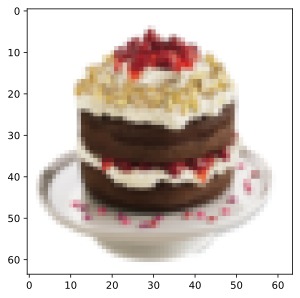

In [79]:
plt.imshow(patch.permute(1, 2, 0))

plt.show()

In [80]:
# name = 'unicorn'  # 'cake' # "homer-simpson"
c = 25
print(c)
train_loader, test_loader, label_names = get_data(10)


eval_patch(model,
               patch,
               test_loader, c, label_names,
               place_patch_=True,
               place_text_=False,
               place_frame_=False,
               font_size=15,
#                alpha=0.2
              )

25


(tensor(0.1626, device='cuda:0'),
 tensor(0.8687, device='cuda:0'),
 tensor(0., device='cuda:0'),
 tensor(0., device='cuda:0'))

In [61]:
from tqdm import tqdm

In [ ]:
print(1)

In [38]:
# name = 'rainbow'  # 'cake' # "homer-simpson"
patch = torch.randn(3, 64, 64)
name = 'homer-simpson'
train_loader, test_loader, label_names = get_data(82)
c = label_names.index(name)
print(c)


for alpha in tqdm([0.1, 0.2, 0.4, 0.6], total=4):
    acc, top5, acc_clean, top5_clean = eval_patch(model,
                   patch,
                   test_loader, c, label_names,
                   place_patch_=False,
                   place_text_=True,
                   place_frame_=False,
                   font_size=15,
                   alpha=alpha
                  )
    print(acc, top5, acc_clean, top5_clean)

103


 25%|██▌       | 1/4 [2:17:21<6:52:05, 8241.86s/it]              

tensor(0.0003, device='cuda:0') tensor(0.0054, device='cuda:0') tensor(0., device='cuda:0') tensor(0., device='cuda:0')



 50%|█████     | 2/4 [4:34:23<4:34:20, 8230.15s/it]              

tensor(0.1701, device='cuda:0') tensor(0.4687, device='cuda:0') tensor(0., device='cuda:0') tensor(0., device='cuda:0')



 75%|███████▌  | 3/4 [6:38:28<2:11:11, 7871.35s/it]              

tensor(0.6394, device='cuda:0') tensor(0.9479, device='cuda:0') tensor(0., device='cuda:0') tensor(0., device='cuda:0')



100%|██████████| 4/4 [8:45:42<00:00, 7885.64s/it]                

tensor(0.8756, device='cuda:0') tensor(0.9934, device='cuda:0') tensor(0., device='cuda:0') tensor(0., device='cuda:0')


Check the transferability of the patch:

In [89]:
import os
import zipfile

path = '/kaggle/working/252_64_epoch_5_ViT-L-14-336_patch_imgs_10203.pt'
with zipfile.ZipFile('zipfile.zip', 'w') as zip:
    zip.write(path)

In [90]:
from IPython.display import FileLink
FileLink(r'zipfile.zip')

/kaggle/working/zipfile.zip

In [ ]:
def get_links(path):
    

In [ ]:
name = 'cake'
with open(f'/kaggle/input/data-patch/result_dict_{name}.pkl', 'wb') as f:
        pickle.dump(result_dict[name], f)

In [56]:
!ls
!mkdir data

cake_64_patch.pt  caltech256  caltech256.zip  data  result_dict_cake.pkl


In [61]:
from IPython.display import FileLink
FileLink(r'/kaggle/working/cake_64_patch.pt')

/kaggle/working/cake_64_patch.pt

In [62]:
import os
import zipfile

path = '/kaggle/working/cake_64_patch.pt'
with zipfile.ZipFile('zipfile.zip', 'w') as zip:
    zip.write(path)

In [63]:
!ls

cake_64_patch.pt  caltech256.zip  result_dict_cake.pkl
caltech256	  data		  zipfile.zip


In [67]:
from IPython.display import FileLink
FileLink(r'result_dict.zip')

/kaggle/working/result_dict.zip

In [66]:
import os
import zipfile

path = '/kaggle/working/result_dict_cake.pkl'
with zipfile.ZipFile('result_dict.zip', 'w') as zip:
    zip.write(path)